In [1]:
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import numpy as np
import math 
import csv
from qmplot import manhattanplot, qqplot
from statsmodels.stats.multitest import multipletests
import warnings
warnings.filterwarnings("ignore")

# read in data

In [2]:
def combine_dataframes(directory, ext, pop): 
    df_list = []
    
    for i in range(1, 23): 
        df = pd.read_csv(f"{directory}/{pop}_{i}{ext}", sep="\t")
        df = df.dropna()
        df_list.append(df)
        
    return pd.concat(df_list)

In [3]:
def return_frequency(directory, ext, pop): 
    
    frq = combine_dataframes(directory, ext, pop)
        
    frq["cluster_size"] = frq["HET_REF_ALT_CTS"] + frq["TWO_ALT_GENO_CTS"]
    frq["name"] = frq["ID"].astype(str) + "_" + frq["#CHROM"].astype(str)
    frq["maf"] = (frq["TWO_ALT_GENO_CTS"] + (frq["HET_REF_ALT_CTS"]/2))/(frq["HET_REF_ALT_CTS"] + frq["TWO_ALT_GENO_CTS"] + frq["HOM_REF_CT"] )
    
    return frq

In [4]:
def return_assoc(directory, ext, pop): 
    
    assoc = combine_dataframes(directory, ext, pop)
    assoc["name"] = assoc["ID"].astype(str) + "_" + assoc["#CHROM"].astype(str)
    assoc["name"] = assoc["ID"].astype(str) + "_" + assoc["#CHROM"].astype(str)

    return assoc

In [5]:
def perform_qc(assoc, frq, min_hom_count=3, max_frq_maf=0.05, std_thresh=3, qc_type="all"): 
    
    min_hom = frq[frq["TWO_ALT_GENO_CTS"] >= min_hom_count]["name"].values
    max_frq = frq[frq["maf"] < 0.05]["name"].values 
    
    mean, std = frq["cluster_size"].mean(), frq["cluster_size"].std()
    cluster_sharing = set(frq[frq["cluster_size"] <= (std_thresh*std) + mean]["name"].values).intersection(min_hom)
    
    all_intersection = set(cluster_sharing).intersection(set(min_hom)).intersection(set(max_frq))
    
    qc_type_dict = {"maf":max_frq, "min_hom":min_hom, "cluster_sharing":cluster_sharing,
                    "all":all_intersection}
    
    return assoc[assoc["name"].isin(qc_type_dict[qc_type])], qc_type_dict

In [6]:
def multiple_test_correction(df, test_type="bonferroni"): 
    
    df[test_type] = multipletests(df["P"], method=test_type)[0]
    df["-log P"] = -(np.log10(df["P"]))

### make dataframes

In [97]:
directory = "all_phenotypes_continuous/phers/cluster2/icurl/"
ext = ".104300.glm.linear"
pop="pr"

assoc = return_assoc(directory, ext, pop)
frq = return_frequency(directory, ".gcount", pop)

# qc 

### run QC 

In [98]:
assoc_qc, qc_dict = perform_qc(assoc, frq, qc_type="min_hom", std_thresh=3 )
multiple_test_correction(assoc_qc)

In [99]:
len(qc_dict["maf"]), len(qc_dict["min_hom"]), len(qc_dict["cluster_sharing"]), len(qc_dict["all"])

(3798801, 6319, 614, 614)

# plots

### P value histogram 

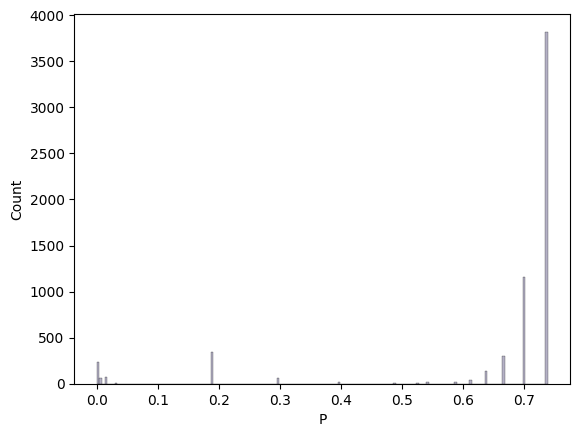

In [100]:
sns.histplot(x="P", data=assoc_qc, color="#9B97B2")
plt.show()

### QQ plot

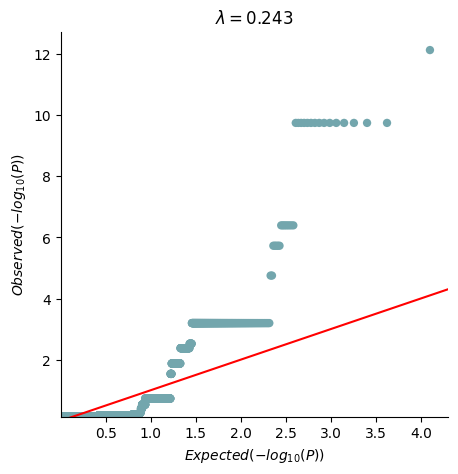

In [101]:
qqplot(data=assoc_qc["P"], color="#73A6AD", alpha=1)
sns.despine()
plt.show()

### manhattan plot

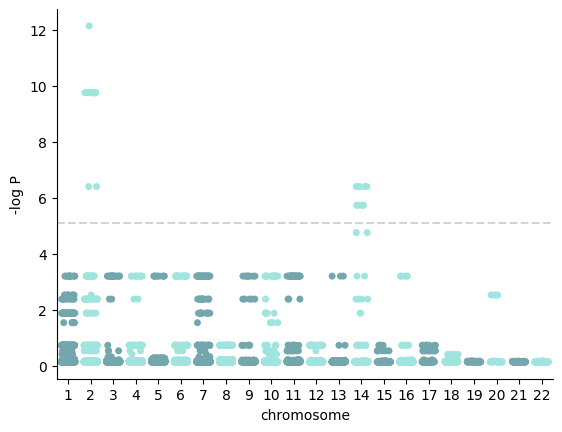

In [102]:
order = [str(i) for i in range(1, 23)]
bonf_line = -np.log10(0.05/len(assoc_qc))

sns.stripplot(x="#CHROM", y="-log P", data=assoc_qc, order=order, jitter=0.3, 
               palette=sns.color_palette(["#73A6AD", "#9FE4DE"]*11))

plt.axhline(y=bonf_line, linestyle="--", color="lightgrey") 
plt.xlabel("chromosome")
sns.despine()
plt.show()

In [104]:
assoc_qc[assoc_qc["bonferroni"] == True].sort_values(by=["#CHROM", "POS"])

,#CHROM,POS,ID,REF,ALT,A1,TEST,OBS_CT,BETA,SE,T_STAT,P,name,bonferroni,-log P
58114,2,34250000,c88681_2,1,2,2,REC,7833,2.08987,0.327224,6.38666,1.792300e-10,c88681_2_2,True,9.746589
184790,2,142500000,c766069_2,1,2,2,REC,7833,2.08987,0.327224,6.38666,1.792300e-10,c766069_2_2,True,9.746589
185185,2,142750000,c767895_2,1,2,2,REC,7833,2.08987,0.327224,6.38666,1.792300e-10,c767895_2_2,True,9.746589
185429,2,143000000,c769018_2,1,2,2,REC,7833,2.08987,0.327224,6.38666,1.792300e-10,c769018_2_2,True,9.746589
185841,2,143250000,c771172_2,1,2,2,REC,7833,2.08987,0.327224,6.38666,1.792300e-10,c771172_2_2,True,9.746589
186232,2,143500000,c772999_2,1,2,2,REC,7833,2.08987,0.327224,6.38666,1.792300e-10,c772999_2_2,True,9.746589
186546,2,143750000,c774519_2,1,2,2,REC,7833,2.08987,0.327224,6.38666,1.792300e-10,c774519_2_2,True,9.746589
186971,2,144000000,c776701_2,1,2,2,REC,7833,2.08987,0.327224,6.38666,1.792300e-10,c776701_2_2,True,9.746589
187224,2,144250000,c777892_2,1,2,2,REC,7833,2.08987,0.327224,6.38666,1.792300e-10,c777892_2_2,True,9.746589
187452,2,144500000,c778908_2,1,2,2,REC,7833,2.08987,0.327224,6.38666,1.792300e-10,c778908_2_2,True,9.746589


In [105]:
# map_file = pd.read_csv("dash_output/aj/dashcc/cluster1_16.map", sep=" ", header=None)
map_file = pd.read_csv("icurl/libd/pr/cluster2_2.map", sep=" ", header=None)
map_file["region"] = "chr" + map_file[0].astype(str) + ":" + map_file[2].astype(str) + "-" + map_file[3].astype(str)

In [106]:
snp = "c1240645_2"

In [82]:
# frq[frq["name"] == snp]

In [83]:
chr2:215000001-231250000
74000001

In [107]:
map_file[map_file[1] == snp ]

,0,1,2,3,region
256424,2,c1240645_2,215000001,215250000,chr2:215000001-215250000


In [15]:
geno = pd.read_csv("comparison/height/dashcc/cluster2_9.raw", sep=" ")

In [16]:
pheno = pd.read_csv("output_regenie/cluster2/height_pheno.txt", sep="\t")

In [17]:
geno_pheno = geno.merge(pheno, on="FID") 

In [19]:
geno_pheno.head()

,FID,IID_x,PAT,MAT,SEX,PHENOTYPE,cs8937_2,IID_y,height
0,1000040,1000040,0,0,0,-9,0,1000040,67.0
1,1002881,1002881,0,0,0,-9,0,1002881,66.0
2,1002900,1002900,0,0,0,-9,0,1002900,61.0
3,1003192,1003192,0,0,0,-9,0,1003192,60.0
4,10037115,10037115,0,0,0,-9,0,10037115,67.0


In [23]:
snp = "cs8937"

In [24]:
geno_pheno[f"{snp}_2"].value_counts()

cs8937_2
0    6043
1     110
2       4
Name: count, dtype: int64

In [26]:
geno_pheno[geno_pheno[f"{snp}_2"] == 2]

,FID,IID_x,PAT,MAT,SEX,PHENOTYPE,cs8937_2,IID_y,height
1380,1555181,1555181,0,0,0,-9,2,1555181,58.0
2086,199817,199817,0,0,0,-9,2,199817,56.0
3269,25408,25408,0,0,0,-9,2,25408,57.0
3603,27900,27900,0,0,0,-9,2,27900,57.0


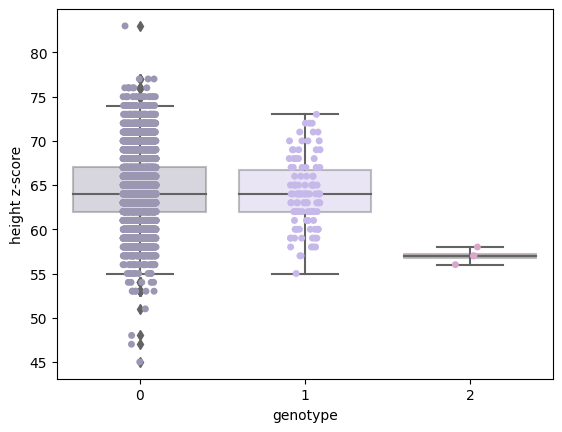

In [25]:
sns.boxplot(x=f"{snp}_2", y="height", data=geno_pheno, boxprops=dict(alpha=0.4),
            palette=sns.color_palette(["#9B97B2", "#C7B8EA", "#D8A7CA"]))
sns.stripplot(x=f"{snp}_2", y="height", data=geno_pheno, alpha=1,
             palette=sns.color_palette(["#9B97B2", "#C7B8EA", "#D8A7CA"]))
plt.xlabel("genotype")
plt.ylabel("height z-score")
plt.show() 